In [1]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node a835a81a-5637-463d-bad9-90867f7ba4d7

In [2]:
from cvision import *
import Kal_FILTER as kfil
import Local_NAV as local
import MotionCTR2 as mctrl
import Kidnapping as kidnap
from Global_NAV_TERMINATOR_VERSION import *


import os
import cv2
import math
import time
import IPython
import matplotlib
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

%matplotlib inline

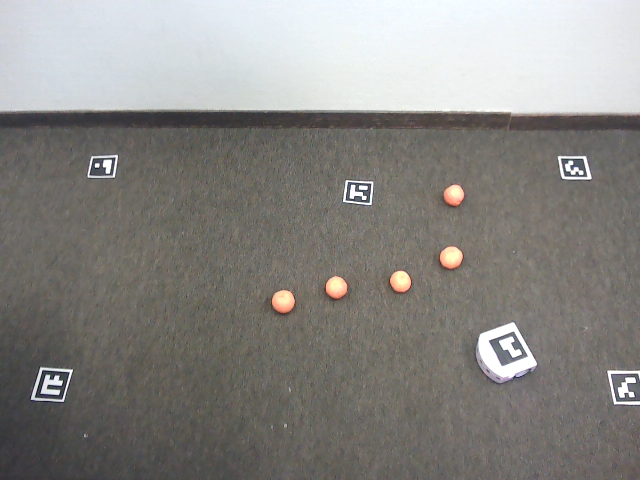

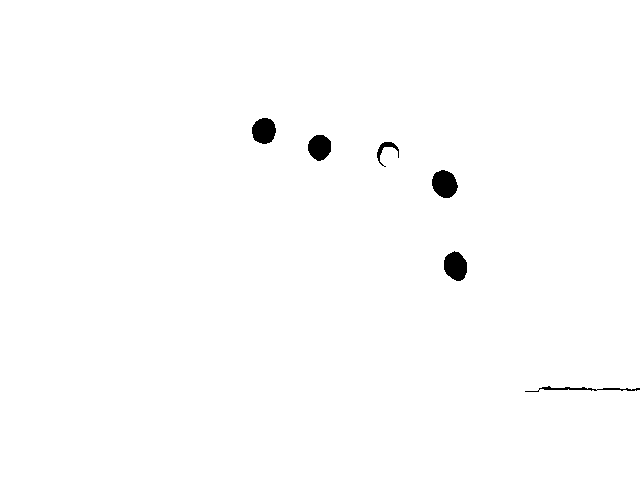

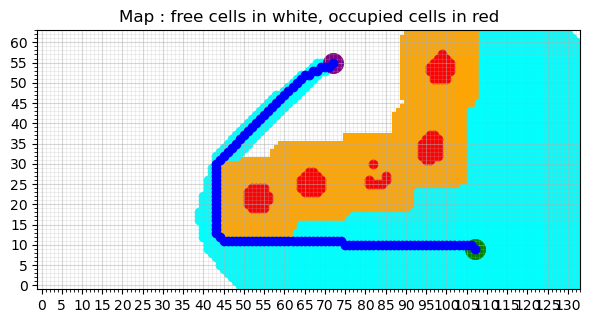

KeyboardInterrupt: 

In [3]:
#General variables
state = 0
not_arrived = True
Ts = 0.5 # Sampling time

#Robot vriables
speed0 = 150
speedGain = 80
motors_speed = [0,0]

#Sensors variable
obst = [0,0,0,0,0]

#Global variable
k = 0
threshold_for_convergence = 50
n = 0
path = []


# Initial state covariance matrix
P_k_minus_1 = np.array([[0.1, 0, 0],
                        [0, 0.1, 0],
                        [0, 0, 0.1]])
P_k = P_k_minus_1
C_conv_toThymio_right = 80 #67.60908181
C_conv_toThymio_left = 80 #67.82946137
L = 65 #mm
R = 23 #mm




# Create an adjusted dictionary of 6 markers of 4x4 bits.
aruco_dictionary = cv2.aruco.extendDictionary(6, 4)

# Assign a marker to each objects to be recognized on the map and generate three reference markers
detector = create_detector(aruco_dictionary)

for i in range(6):
    marker = cv2.aruco.generateImageMarker(aruco_dictionary, i, 500, np.zeros((6, 6, 1), dtype="uint8"), 1)
    cv2.imwrite('marker' + str(i) +'.jpg', marker)
    
# Definition of the references used to map the space
ref1 = Obj(0, np.array([]))
ref2 = Obj(1, np.array([]))
ref3 = Obj(2, np.array([]))
ref4 = Obj(3, np.array([]))

# Definition of the objects to recognize in the space
goal = Obj(5, np.array([]))
thymio = Obj(4, np.array([]))
map = Map(ref1,ref2,ref3,ref4,1330,630)
objects = np.array([ref1,ref2,ref3,ref4,goal,thymio])

# Open the video and for a livestream
video = cv2.VideoCapture(0)

if (video.isOpened()== False): 
    print("Error opening video stream or file")
    
for i in range(50):
    ret,frame = video.read()
    time.sleep(0.1)

while True:
    if state == 0: #Initialisation state of the robot
       
        # Recognition of the view with the map and path planning
        path_found = False
        while not (path_found):
            ret, frame = video.read()
            
            if ret == True:
                clear_output(wait=True)
                show_frame(frame)
                detect_objects(frame, detector, objects)
                
                if map.references_detected():
                    corrected_image = map.corrected_view(frame, objects)
                    matrix = map.matrix(corrected_image, thymio, goal)
                    if check_matrix(matrix):
                        path, visitedNodes, occupancy_grid, obstacle_indices = global_path(matrix)
                        print_path(matrix, path, visitedNodes, occupancy_grid, obstacle_indices)
                        path = np.multiply(path, 10)
                        key_points = calculate_angles_along_path(path)
                        initial_key_points = len(key_points[0])- 1
                        N = np.size(path,1)
                        path_found = True
                        state_estimate_k = np.array([map.localize(thymio)[0][0],map.localize(thymio)[0][1],-vector_to_angle(map.vec_img2map(thymio.get_img_dir()[0]))])
                        
        state = 1 
        
    if state == 1: #Robot is in global mode
        current_states= [[]]
        path_to_follow = [[path[0,k],path[1,k]]]
        
        while not_arrived == True:
            #CHECK FOR OBSTACLES
            prox_horizontal = local.read_prox_sensors(node,client)
            obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
            state = local.update_state(state,obst,client)
            
            if state == 2:
                break
                
            #CHECK KIDNAPPING
            if kidnap.read_acc_sensors(node,client) > 24:
                mctrl.stop_motors(node)
                time.sleep(1)
                state = 0
                break

            # Path following: control law
            vr, vl = mctrl.control_law(state_estimate_k, key_points[0][k], key_points[1][k],speed0,speedGain)
            control_vector_k_minus_1 = np.array([vr/C_conv_toThymio_right,vl/C_conv_toThymio_left]) #if we use [vr,vl] as control variables in state space model
            mctrl.set_motors(vl,vr,node)
            
            
            # Take Thymio position if camera is not obstructed and update state estimate with kalman filter
            if video.isOpened:
                ret, frame = video.read()
                if ret == True:
                    
                    #clear_output(wait=True)
                    detect_objects(frame, detector, objects)  
                    
                    if map.references_detected(): #camera correctly working
                        camera_obstructed = 0
                        corrected_image = map.corrected_view(frame,objects)
                        ref1.draw(corrected_image, [255,0,0])
                        ref2.draw(corrected_image, [0,255,0])
                        ref3.draw(corrected_image, [0,0,255])
                        ref4.draw(corrected_image, [0,0,255])                    
                        goal.draw(corrected_image, [255,255,255])
                        thymio.draw(corrected_image, [255,0,0])
                        if np.size(map.localize(thymio), 0) > 0: #camera working correctly
                            z_k_observation_vector = np.array([map.localize(thymio)[0][0],map.localize(thymio)[0][1],-vector_to_angle(map.vec_img2map(thymio.get_img_dir()[0]))])  
                            print('Z_k', z_k_observation_vector)
                            state_estimate_k,P_k_minus_1 = kfil.ekf(z_k_observation_vector, state_estimate_k, control_vector_k_minus_1, P_k_minus_1, Ts, camera_obstructed)
                            current_states.append(state_estimate_k)
                            
                    else: #camera obstructed
                        camera_obstructed = 1
                        z_k_observation_vector = np.array([0,0,0])
                        state_estimate_k,P_k_minus_1 = kfil.ekf(z_k_observation_vector, state_estimate_k, control_vector_k_minus_1, P_k_minus_1, Ts, camera_obstructed) 

            # Check if the robot has arrived to the temporary goal
            if np.linalg.norm(state_estimate_k[:2] - np.array([key_points[0][k], key_points[1][k]])) < threshold_for_convergence:
                if n == initial_key_points:
                    not_arrived = False
                    state = 3
                    break

                else:
                    key_points[0].pop(k)
                    key_points[1].pop(k)
                    n = n + 1
                    
            time.sleep(Ts)   


   
    if state == 2:  # Local navigation state
        memory_speed = mctrl.memory_speed(vr,vl)
        prox_horizontal = local.read_prox_sensors(node,client)
        obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
        motors_speed = local.local_navigation(obst,speed0)
        mctrl.set_motors(motors_speed[0],motors_speed[1],node)       
        state = local.update_state(state,obst,client)
        
        if state == 1:
            if map.references_detected():
                if np.size(map.localize(thymio), 0) > 0:
                    z_k_observation_vector = np.array([map.localize(thymio)[0][0],map.localize(thymio)[0][1],-vector_to_angle(map.vec_img2map(thymio.get_img_dir()[0]))])
                    state_estimate_k,P_k_minus_1 = kfil.ekf(z_k_observation_vector, state_estimate_k, control_vector_k_minus_1, P_k_minus_1, Ts, camera_obstructed)
                
            else:
                camera_obstructed = 1
                z_k_observation_vector = np.array([0,0,0])
                state_estimate_k,P_k_minus_1 = kfil.ekf(z_k_observation_vector, state_estimate_k, control_vector_k_minus_1, P_k_minus_1, Ts, camera_obstructed) 
                
            closest_index = find_closest_keypoint_index(state_estimate_k[:2], key_points)
            angle = calculate_angle_between_robot_and_closest(state_estimate_k[:2], key_points, closest_index)
            length_of_keypoints = len(key_points[0]) - 1
            
            while abs(angle) > 50:
                if length_of_keypoints > 1:
                    distances = calculate_distances_to_keypoints(state_estimate_k[:2], key_points)
                    next_closest_index = find_next_closest_keypoint(state_estimate_k[:2], key_points, distances, closest_index)
                    closest_index = next_closest_index
                    angle = calculate_angle_between_robot_and_closest(state_estimate_k[:2], key_points, closest_index)
                    length_of_keypoints = length_of_keypoints - 1
                    
                else:
                    closest_index = length_of_keypoints
                    break
                    
            closest_keypoint = [[key_points[0][closest_index]],[key_points[1][closest_index]]]
            [vr_glob, vl_glob] = mctrl.return_memory_speed(memory_speed)
            vr, vl = mctrl.control_law(state_estimate_k, closest_keypoint[0], closest_keypoint[1],speed0,speedGain)
            mctrl.set_motors((vl+vl_glob),(vr+vr_glob),node)
            client.sleep(0.7)
            
    if state == 3:
        mctrl.stop_motors(node)
        break     

       


In [4]:
mctrl.stop_motors(node)